In [16]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 13,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [112]:
#Lines from the excel files
VIS_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\valores_VIS.xlsx")
NIR_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\valores_NIR.xlsx")
SPA_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Spatially Resolved Atlas\values_SPA.xlsx")
ALL_data = pd.concat([VIS_data,NIR_data],axis=0).drop_duplicates('Observed wavelength',keep='first').reset_index(drop=True) #Dont take repeated values when concatenate

## Gray and Oostra standard curve

### Give a third order polynomial fit for each color

The range used on Gray and Oostra article for the standard curve was 6020–6340 Å, we can stablish just a green range (4970-5700 Å) for comparised and report all the color curves started on violet range.

For consistency, the standard curve is comparised only using the visible range for the solar flux atlas.

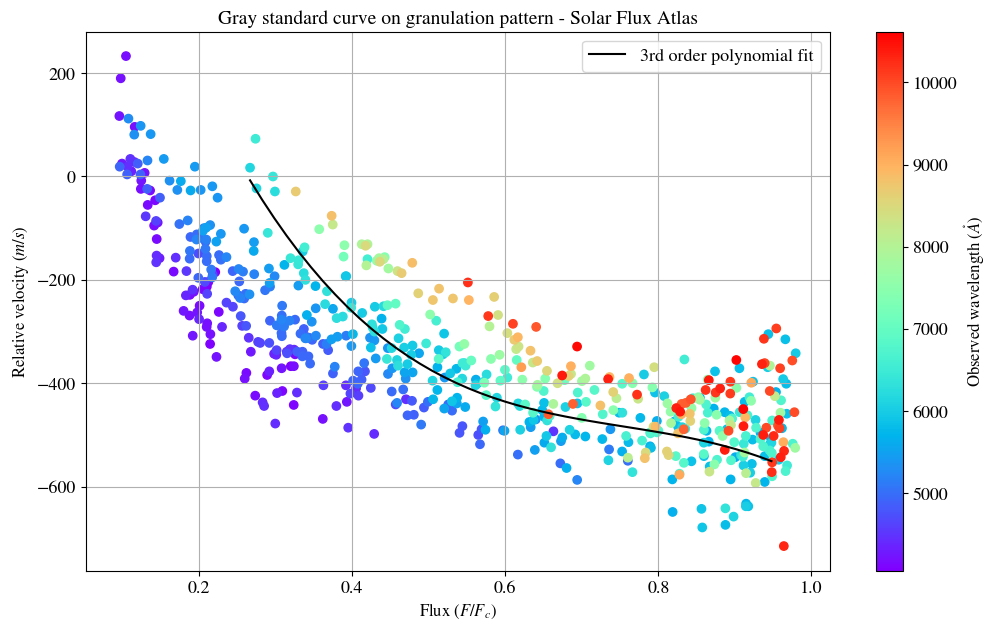

In [83]:
#Take the range from Gray and Oostra
values_VIS_standard = VIS_data[VIS_data['Observed wavelength'].between(6020,6340, inclusive='right')]

fig1, ax = plt.subplots(1,1,figsize=(12,7))

ax.set_title(r'Gray standard curve on granulation pattern - Solar Flux Atlas')

pol = Polynomial.fit(values_VIS_standard['Flux'],values_VIS_standard['Velocity'], 3)
param = pol.convert().coef
values_flux = np.linspace(min(values_VIS_standard['Flux']), max(values_VIS_standard['Flux']), len(values_VIS_standard['Flux']))
flux_fit = poly.polyval(values_flux,param)

scatter = ax.scatter(VIS_data['Flux'],VIS_data['Velocity'],c=VIS_data["Observed wavelength"],cmap='rainbow',lw=1,marker='o')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.plot(values_flux,flux_fit,color='k',label='3rd order polynomial fit')

ax.set_xlabel(r'Flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Relative velocity $(m/s)$',fontsize=12)
ax.legend()
ax.grid()

# fig1.savefig('Standard curve_Gray.pdf')

The report is only for the specific range and shifted the curved +633 m/s

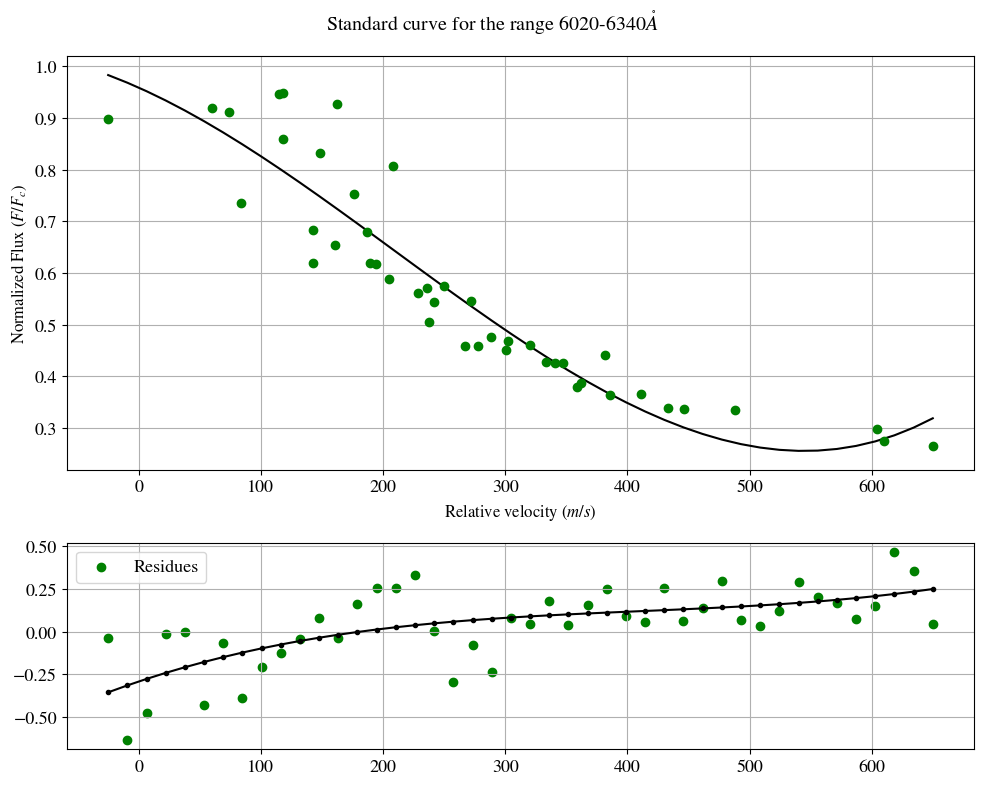

In [111]:
#In the report is given in function of the velocity

pol = Polynomial.fit(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], 3)
param = pol.convert().coef
values_vel = np.linspace(min(values_VIS_standard['Velocity']+633), max(values_VIS_standard['Velocity']+633), len(values_VIS_standard))
vel_fit = pol(values_vel)

#Calculate the residues
residuos = (values_VIS_standard['Flux']) - vel_fit
std_flux = np.std(residuos) 

#Plot for fixed the zero point of velocity
fig2, axis = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis[0]
ax2 = axis[1]

fig2.suptitle(r'Standard curve for the range 6020-6340$\mathring{A}$')

ax1.errorbar(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], capsize=6,fmt='o', color='green')
ax1.plot(values_vel,vel_fit,c='k')
ax1.set_ylabel(r'Normalized Flux $(F/F_{c})$')
ax1.set_xlabel(r'Relative velocity $(m/s)$')
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

#Check if there a polynomial correction on the residues
pol_res = Polynomial.fit(values_vel,residuos, 3)
param_res = pol_res.convert().coef #Parameters to correct
values_res = np.linspace(min(values_vel), max(values_vel), len(values_vel))
res_fit = poly.polyval(values_res,param_res)

ax2.scatter(values_vel,residuos,c='green',label='Residues')
ax2.plot(values_res,res_fit,c='k',marker='.')
ax2.grid()
ax2.legend()
ax2.tick_params(axis='both',labelsize=13)


fig2.tight_layout()

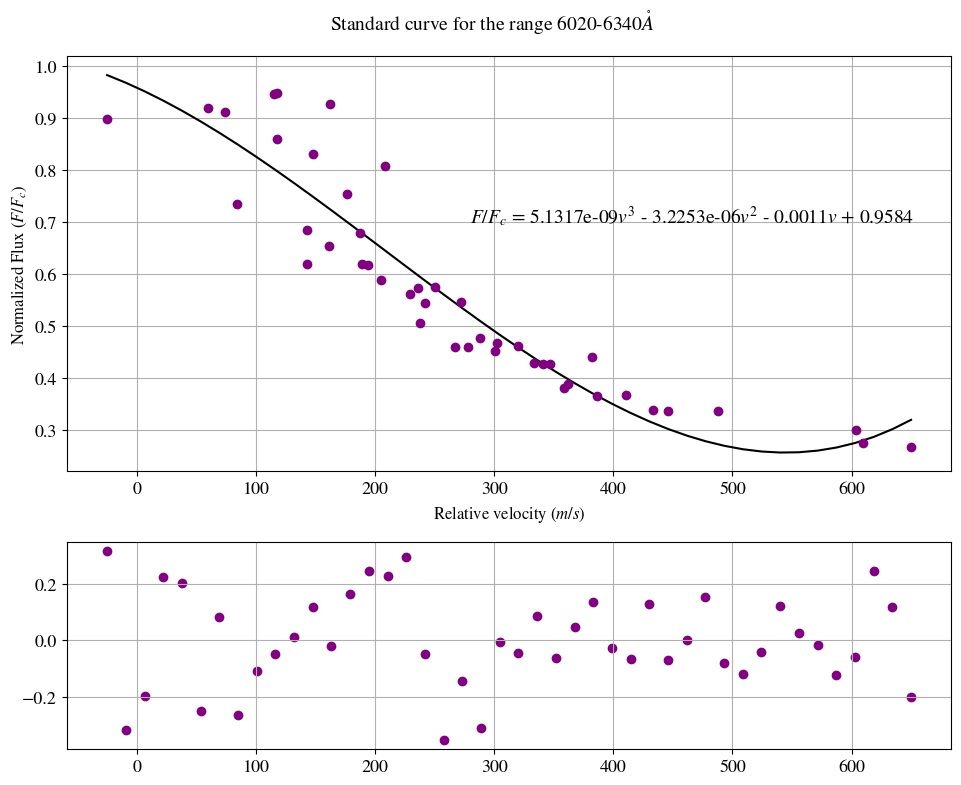

In [80]:
#Ajuste de errores basados en los residuos del ajuste
pol = Polynomial.fit(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], 3)
param = pol.convert().coef
values_vel = np.linspace(min(values_VIS_standard['Velocity']+633), max(values_VIS_standard['Velocity']+633), len(values_VIS_standard))
vel_fit = poly.polyval(values_vel,param+param_res)

residuos = (values_VIS_standard['Flux']) - vel_fit
std_flux = np.std(residuos) 

#Gráfico con residuos
fig, axis = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis[0]
ax2 = axis[1]

fig.suptitle(r'Standard curve for the range 6020-6340$\mathring{A}$',fontsize=14)

ax1.errorbar(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], capsize=6,fmt='o', color='purple')
ax1.plot(values_vel,pol(values_vel),c='k')
ax1.set_ylabel(r'Normalized Flux $(F/F_{c})$',fontsize=12)
ax1.set_xlabel(r'Relative velocity $(m/s)$',fontsize=12)
ax1.text(280, 0.7, r'$F/F_c$ = {}$v^3$ - {}$v^2$ - {}$v$ + {}'.format(round(param[3],14),-round(param[2],10),-round(param[1],4),round(param[0],4)),color='k',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(values_vel,residuos,c='purple')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)


fig.tight_layout()
#plt.savefig('Calibration_standard_curve.pdf')

In [115]:
param

array([ 9.58438970e-01, -1.05528079e-03, -3.22527864e-06,  5.13169816e-09])

In [66]:
print(r'F/F_c = {}v^3 - {}v^2 - {}v + {}'.format(round(param[3],14),-round(param[2],10),-round(param[1],4),round(param[0],4)))

F/F_c = 5.1317e-09v^3 - 3.2253e-06v^2 - 0.0011v + 0.9584


Now, we define the new standard curve (all green range) with their respectives shifts and yes, we include the near infrared.

In [113]:
#Separate for range in colors for color fits

values_ALL = [ ALL_data[ALL_data['Observed wavelength'].between(3800, 4270, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(4270, 4760, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(4760, 4970, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(4970, 5700, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(5700, 5810, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(5810, 6180, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(6180, 7800, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(7800, 10000, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(10000, 23000, inclusive='right')]]

#colors for the plot
colors_fit = ['purple','blue','cyan','green','yellow','orange','red','brown','darkred']

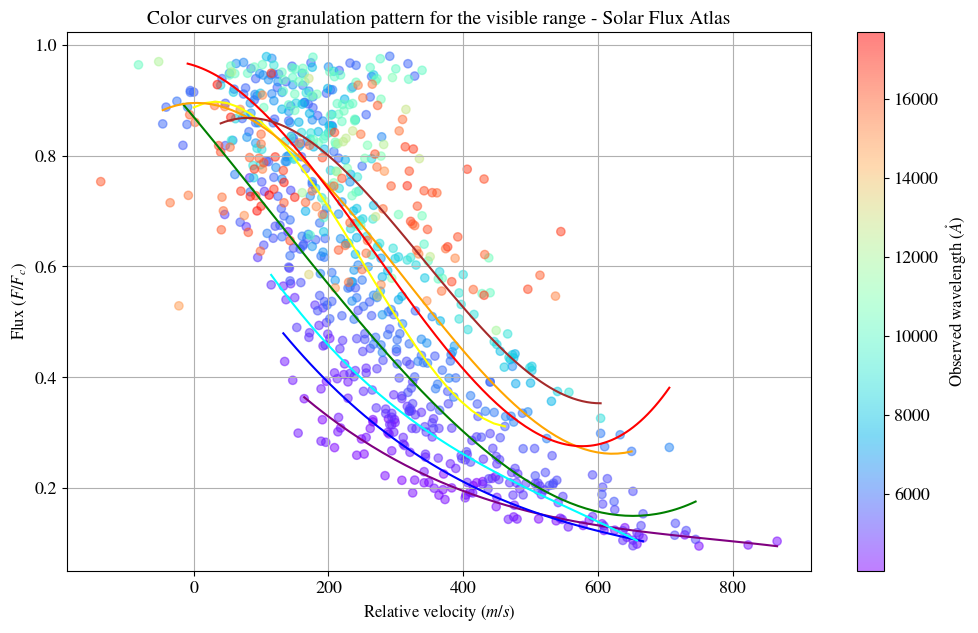

In [107]:
#List for the data
param_ALL = []
fit_ALL = []

fig5, ax = plt.subplots(1,1,figsize=(12,7))

#Plot the cuadratic fit for each color
for i in range(0,len(values_ALL)-1):  
    
    pol = Polynomial.fit(values_ALL[i]['Velocity']+633,values_ALL[i]['Flux'], 3)
    param = pol.convert().coef
    values_flux = np.linspace(min(values_ALL[i]['Velocity']+633), max(values_ALL[i]['Velocity']+633), len(values_ALL[i]))
    flux_fit = poly.polyval(values_flux,param)

    ax.plot(values_flux,flux_fit, color=colors_fit[i])

    param_ALL.append(pd.DataFrame(param[-1::-1]))
    fit_ALL.append([values_flux,flux_fit])

scatter = ax.scatter(ALL_data['Velocity']+633,ALL_data['Flux'],c=ALL_data["Observed wavelength"],cmap='rainbow',lw=1,marker='o', alpha=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Color curves on granulation pattern for the visible range - Solar Flux Atlas')
ax.set_ylabel(r'Flux $(F/F_{c})$')
ax.set_xlabel(r'Relative velocity $(m/s)$')
ax.grid()

# fig5.savefig('ColorCurves_VIS.pdf')

In [109]:
#Calculate te average and show the parameters
parameters_ALL = pd.concat(param_ALL,axis=1)
parameters_ALL = parameters_ALL.set_axis(colors_fit[0:-1], axis=1)
parameters_ALL = parameters_ALL.T.set_axis(['ax^3','bx^2','cx','d'],axis=1)

parameters_ALL

,ax^3,bx^2,cx,d
purple,-8.106860e-10,1.875354e-06,-0.001570,0.574638
blue,-1.076716e-09,2.417030e-06,-0.002043,0.710879
cyan,-1.816828e-09,3.106743e-06,-0.002336,0.815108
green,1.756883e-09,-5.988745e-07,-0.001461,0.869864
yellow,1.381408e-08,-1.047115e-05,0.000643,0.887068
orange,5.371860e-09,-5.040399e-06,0.000039,0.895112
red,6.005084e-09,-4.859311e-06,-0.000386,0.962962
brown,7.216710e-09,-7.405319e-06,0.001055,0.827429


In [ ]:
# The reference point is the green part, the color coefficient is waht are in the table
scale_coeff = pd.DataFrame()
scale_coeff['3rd order'] = parameters_ALL['ax^3']/parameters_ALL['ax^3'].iloc[3]
scale_coeff['2nd order'] = parameters_ALL['bx^2']/parameters_ALL['bx^2'].iloc[3]
scale_coeff['1st order'] = parameters_ALL['cx']/parameters_ALL['cx'].iloc[3]
scale_coeff['Shift'] = parameters_ALL['d']/parameters_ALL['d'].iloc[3]
scale_coeff

,3rd order,2nd order,1st order,Shift
purple,-0.461434,-3.131464,1.074737,0.660607
blue,-0.612856,-4.035954,1.398558,0.817230
cyan,-1.034120,-5.187636,1.599430,0.937053
green,1.000000,1.000000,1.000000,1.000000
yellow,7.862839,17.484712,-0.440246,1.019778
orange,3.057609,8.416453,-0.026795,1.029026
red,3.418034,8.114073,0.264627,1.107026
brown,4.107679,12.365395,-0.722222,0.951216
